In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import warnings
import optuna
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

c:\Users\jiahe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\test.csv")
train = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\train.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (517754, 14)
Test shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
train.isnull().sum().sort_values(ascending=False).head(10)

id                    0
road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
dtype: int64

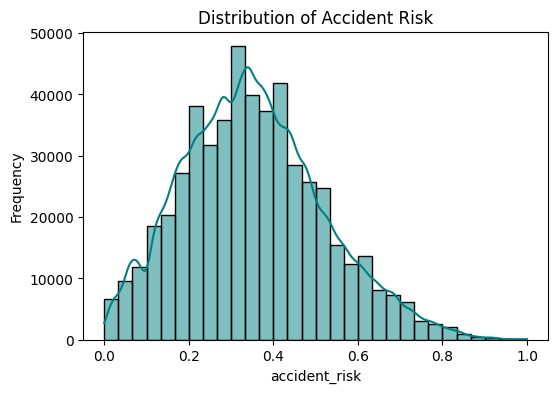

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(train['accident_risk'], bins=30, kde=True, color='teal')
plt.title("Distribution of Accident Risk")
plt.xlabel("accident_risk")
plt.ylabel("Frequency")
plt.show()

In [5]:
train_cat = train.copy()
test_cat = test.copy()

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

for col in cat_cols:
    categories = pd.Categorical(pd.concat([train_cat[col], test_cat[col]], axis=0)).categories
    train_cat[col] = pd.Categorical(train_cat[col], categories=categories)
    test_cat[col] = pd.Categorical(test_cat[col], categories=categories)

In [6]:
# List of categorical columns to target encode
target_encode_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

# Initialize KFold for target encoding
kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_features = pd.DataFrame(index=train.index)

for col in target_encode_cols:
    print(f"Target encoding: {col}")
    oof = pd.Series(np.nan, index=train.index)

    # Create out-of-fold mean for each category
    for train_idx, val_idx in kf.split(train):
        means = train.iloc[train_idx].groupby(col)['accident_risk'].mean()
        oof.iloc[val_idx] = train.iloc[val_idx][col].astype(str).map(means)


    encoded_features[col + '_te'] = oof

# Add encoded features to train
train = pd.concat([train, encoded_features], axis=1)

# Apply same encoding (using full-train mean) to test
for col in target_encode_cols:
    global_mean = train.groupby(col)['accident_risk'].mean()
    test[col + '_te'] = test[col].astype(str).map(global_mean)

Target encoding: road_type
Target encoding: lighting
Target encoding: weather
Target encoding: time_of_day


In [7]:
# =====================================================
# === Define baseline analytic function and clipper ===
# =====================================================
def f_base(X):
    """Simple analytic approximation of accident risk."""
    return (
        0.3 * X["curvature"]
        + 0.2 * (X["lighting"] == "night").astype(int)
        + 0.1 * (X["weather"] != "clear").astype(int)
        + 0.2 * (X["speed_limit"] >= 60).astype(int)
        + 0.1 * (X["num_reported_accidents"] > 2).astype(int)
    )

def clip(f, sigma=0.05):
    """Smoothly clip predictions into [0,1] using truncated normal expectation."""
    def clip_f(X):
        mu = f(X)
        a, b = -mu/sigma, (1 - mu)/sigma
        Phi_a, Phi_b = st.norm.cdf(a), st.norm.cdf(b)
        phi_a, phi_b = st.norm.pdf(a), st.norm.pdf(b)
        return mu*(Phi_b - Phi_a) + sigma*(phi_a - phi_b) + 1 - Phi_b
    return clip_f

# Apply baseline to train and test
train["y_base"] = clip(f_base)(train)
test["y_base"] = clip(f_base)(test)

# Compute residual target
train["y_resid"] = train["accident_risk"] - train["y_base"]

In [8]:
X = train_cat.drop(columns=['id', 'accident_risk'])
y = train['y_resid']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
importances = pd.DataFrame()
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_fs = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model_fs.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(100)]
    )

    fold_importance = pd.DataFrame({
        'feature': X.columns,
        'gain': model_fs.booster_.feature_importance(importance_type='gain'),
        'fold': fold + 1
    })
    importances = pd.concat([importances, fold_importance], axis=0)

# Compute feature importance
importance_df = (
    importances.groupby('feature')['gain']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Filter weak features
threshold = importance_df['gain'].median() * 0.1
selected_features = importance_df.query('gain > @threshold')['feature'].tolist()

print(f"✅ Selected {len(selected_features)} / {len(X.columns)} features after multi-fold averaging.")

# Reduce the dataset to selected features
X = X[selected_features]
test_X = test_cat[selected_features]

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score -0.000177
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0562943	valid_0's l2: 0.00316905
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score -0.000280
Trai

In [10]:
def objective(trial):
    params = {
        "n_estimators": 8000,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[optuna.integration.LightGBMPruningCallback(trial, "rmse")]
        )
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        
    return np.mean(rmse_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)

best_params = study.best_params

[I 2025-10-24 14:01:45,330] A new study created in memory with name: no-name-32dc8a82-82a5-444f-a492-2e956e25f2aa
Best trial: 0. Best value: 0.0560672:   2%|▎         | 1/40 [02:22<1:32:49, 142.81s/it]

[I 2025-10-24 14:04:08,134] Trial 0 finished with value: 0.05606720500418814 and parameters: {'learning_rate': 0.011012150561776828, 'num_leaves': 122, 'max_depth': 7, 'subsample': 0.7636510251630448, 'colsample_bytree': 0.8768848675375591, 'reg_alpha': 0.7360338110880995, 'reg_lambda': 0.45220681416529496, 'min_child_samples': 88}. Best is trial 0 with value: 0.05606720500418814.


Best trial: 0. Best value: 0.0560672:   5%|▌         | 2/40 [08:00<2:43:10, 257.64s/it]

[I 2025-10-24 14:09:46,150] Trial 1 finished with value: 0.056171452663222834 and parameters: {'learning_rate': 0.00825046479614042, 'num_leaves': 144, 'max_depth': 10, 'subsample': 0.8256840640153746, 'colsample_bytree': 0.7565835283655855, 'reg_alpha': 0.23543312145048578, 'reg_lambda': 0.5839080017377728, 'min_child_samples': 140}. Best is trial 0 with value: 0.05606720500418814.


Best trial: 0. Best value: 0.0560672:   8%|▊         | 3/40 [11:54<2:32:08, 246.73s/it]

[I 2025-10-24 14:13:39,891] Trial 2 finished with value: 0.056086191103505253 and parameters: {'learning_rate': 0.008017581426955564, 'num_leaves': 52, 'max_depth': 8, 'subsample': 0.877607377525631, 'colsample_bytree': 0.673744984424818, 'reg_alpha': 0.5833585830268923, 'reg_lambda': 0.35563908988809423, 'min_child_samples': 179}. Best is trial 0 with value: 0.05606720500418814.


Best trial: 0. Best value: 0.0560672:  10%|█         | 4/40 [14:17<2:03:27, 205.76s/it]

[I 2025-10-24 14:16:02,835] Trial 3 finished with value: 0.05616756952696256 and parameters: {'learning_rate': 0.016241348550283943, 'num_leaves': 191, 'max_depth': 4, 'subsample': 0.6061229783139543, 'colsample_bytree': 0.812861387814124, 'reg_alpha': 0.15603981425191282, 'reg_lambda': 0.8731528781568175, 'min_child_samples': 149}. Best is trial 0 with value: 0.05606720500418814.


Best trial: 0. Best value: 0.0560672:  12%|█▎        | 5/40 [16:35<1:45:46, 181.32s/it]

[I 2025-10-24 14:18:20,831] Trial 4 finished with value: 0.056075016616398285 and parameters: {'learning_rate': 0.02273179062701595, 'num_leaves': 131, 'max_depth': 7, 'subsample': 0.7140366736523036, 'colsample_bytree': 0.6861099880852272, 'reg_alpha': 0.41965284442267003, 'reg_lambda': 0.6224832322832969, 'min_child_samples': 34}. Best is trial 0 with value: 0.05606720500418814.


Best trial: 0. Best value: 0.0560672:  15%|█▌        | 6/40 [16:40<1:08:43, 121.28s/it]

[I 2025-10-24 14:18:25,548] Trial 5 pruned. Trial was pruned at iteration 792.


Best trial: 0. Best value: 0.0560672:  18%|█▊        | 7/40 [16:40<44:56, 81.70s/it]   

[I 2025-10-24 14:18:25,770] Trial 6 pruned. Trial was pruned at iteration 0.


Best trial: 0. Best value: 0.0560672:  20%|██        | 8/40 [16:43<30:15, 56.74s/it]

[I 2025-10-24 14:18:29,075] Trial 7 pruned. Trial was pruned at iteration 514.


Best trial: 0. Best value: 0.0560672:  22%|██▎       | 9/40 [22:56<1:20:20, 155.51s/it]

[I 2025-10-24 14:24:41,742] Trial 8 finished with value: 0.05622997905013203 and parameters: {'learning_rate': 0.01611291874404269, 'num_leaves': 117, 'max_depth': 8, 'subsample': 0.7980802299898127, 'colsample_bytree': 0.7920779906091275, 'reg_alpha': 0.19353729985474644, 'reg_lambda': 0.41124822488949453, 'min_child_samples': 111}. Best is trial 0 with value: 0.05606720500418814.


Best trial: 0. Best value: 0.0560672:  25%|██▌       | 10/40 [22:56<53:46, 107.56s/it] 

[I 2025-10-24 14:24:41,953] Trial 9 pruned. Trial was pruned at iteration 0.


Best trial: 10. Best value: 0.056042:  28%|██▊       | 11/40 [26:01<1:03:25, 131.23s/it]

[I 2025-10-24 14:27:46,841] Trial 10 finished with value: 0.056042030077783564 and parameters: {'learning_rate': 0.04844640904740081, 'num_leaves': 94, 'max_depth': 10, 'subsample': 0.7604444986789272, 'colsample_bytree': 0.6097569528290969, 'reg_alpha': 0.9640287815171679, 'reg_lambda': 0.16601924946931562, 'min_child_samples': 74}. Best is trial 10 with value: 0.056042030077783564.


Best trial: 10. Best value: 0.056042:  30%|███       | 12/40 [26:01<42:38, 91.38s/it]   

[I 2025-10-24 14:27:47,073] Trial 11 pruned. Trial was pruned at iteration 0.


Best trial: 10. Best value: 0.056042:  32%|███▎      | 13/40 [28:28<48:36, 108.00s/it]

[I 2025-10-24 14:30:13,336] Trial 12 finished with value: 0.05604527416427644 and parameters: {'learning_rate': 0.045977614659510155, 'num_leaves': 90, 'max_depth': 10, 'subsample': 0.7533993483597535, 'colsample_bytree': 0.6943111167770684, 'reg_alpha': 0.7259733981426157, 'reg_lambda': 0.17718778775167096, 'min_child_samples': 69}. Best is trial 10 with value: 0.056042030077783564.


Best trial: 10. Best value: 0.056042:  35%|███▌      | 14/40 [28:28<32:41, 75.45s/it] 

[I 2025-10-24 14:30:13,553] Trial 13 pruned. Trial was pruned at iteration 0.


Best trial: 14. Best value: 0.056029:  38%|███▊      | 15/40 [31:05<41:42, 100.09s/it]

[I 2025-10-24 14:32:50,742] Trial 14 finished with value: 0.05602899291508443 and parameters: {'learning_rate': 0.03246292729690588, 'num_leaves': 94, 'max_depth': 10, 'subsample': 0.6746239528075708, 'colsample_bytree': 0.6941373876715184, 'reg_alpha': 0.874945324402142, 'reg_lambda': 0.01717666816276578, 'min_child_samples': 22}. Best is trial 14 with value: 0.05602899291508443.


Best trial: 14. Best value: 0.056029:  40%|████      | 16/40 [33:37<46:18, 115.76s/it]

[I 2025-10-24 14:35:22,899] Trial 15 finished with value: 0.05604522527082305 and parameters: {'learning_rate': 0.03061142577836808, 'num_leaves': 65, 'max_depth': 9, 'subsample': 0.6506010917254546, 'colsample_bytree': 0.6482237093640637, 'reg_alpha': 0.9183128980663604, 'reg_lambda': 0.03449144165167197, 'min_child_samples': 26}. Best is trial 14 with value: 0.05602899291508443.


Best trial: 14. Best value: 0.056029:  42%|████▎     | 17/40 [36:08<48:26, 126.36s/it]

[I 2025-10-24 14:37:53,920] Trial 16 finished with value: 0.056035721767999716 and parameters: {'learning_rate': 0.031210297236333916, 'num_leaves': 105, 'max_depth': 9, 'subsample': 0.6606058062675033, 'colsample_bytree': 0.7135076934683395, 'reg_alpha': 0.8035865286987354, 'reg_lambda': 0.270899496482499, 'min_child_samples': 49}. Best is trial 14 with value: 0.05602899291508443.


Best trial: 14. Best value: 0.056029:  45%|████▌     | 18/40 [42:53<1:17:00, 210.02s/it]

[I 2025-10-24 14:44:38,690] Trial 17 finished with value: 0.05714088775464153 and parameters: {'learning_rate': 0.03176455019646222, 'num_leaves': 154, 'max_depth': 9, 'subsample': 0.6297647563041401, 'colsample_bytree': 0.713730766581189, 'reg_alpha': 0.022878140096728283, 'reg_lambda': 0.3028207401901917, 'min_child_samples': 51}. Best is trial 14 with value: 0.05602899291508443.


Best trial: 14. Best value: 0.056029:  48%|████▊     | 19/40 [42:54<51:31, 147.21s/it]  

[I 2025-10-24 14:44:39,571] Trial 18 pruned. Trial was pruned at iteration 128.


Best trial: 14. Best value: 0.056029:  50%|█████     | 20/40 [42:54<34:21, 103.08s/it]

[I 2025-10-24 14:44:39,796] Trial 19 pruned. Trial was pruned at iteration 0.


Best trial: 14. Best value: 0.056029:  52%|█████▎    | 21/40 [42:54<22:52, 72.21s/it] 

[I 2025-10-24 14:44:40,047] Trial 20 pruned. Trial was pruned at iteration 0.


Best trial: 14. Best value: 0.056029:  55%|█████▌    | 22/40 [45:22<28:28, 94.89s/it]

[I 2025-10-24 14:47:07,834] Trial 21 finished with value: 0.05604550088195485 and parameters: {'learning_rate': 0.03590088305195738, 'num_leaves': 82, 'max_depth': 10, 'subsample': 0.6017258134615979, 'colsample_bytree': 0.6426100193110597, 'reg_alpha': 0.9936537466594118, 'reg_lambda': 0.12771168975913613, 'min_child_samples': 71}. Best is trial 14 with value: 0.05602899291508443.


Best trial: 14. Best value: 0.056029:  57%|█████▊    | 23/40 [45:22<18:50, 66.49s/it]

[I 2025-10-24 14:47:08,066] Trial 22 pruned. Trial was pruned at iteration 0.


Best trial: 14. Best value: 0.056029:  60%|██████    | 24/40 [48:27<27:11, 101.95s/it]

[I 2025-10-24 14:50:12,750] Trial 23 finished with value: 0.05605198824610157 and parameters: {'learning_rate': 0.02422450315193157, 'num_leaves': 83, 'max_depth': 10, 'subsample': 0.7841719561395123, 'colsample_bytree': 0.8250166513553052, 'reg_alpha': 0.6404341689830199, 'reg_lambda': 0.1076350661959743, 'min_child_samples': 42}. Best is trial 14 with value: 0.05602899291508443.


Best trial: 14. Best value: 0.056029:  62%|██████▎   | 25/40 [48:27<17:51, 71.44s/it] 

[I 2025-10-24 14:50:12,995] Trial 24 pruned. Trial was pruned at iteration 2.


Best trial: 25. Best value: 0.056029:  65%|██████▌   | 26/40 [50:57<22:11, 95.09s/it]

[I 2025-10-24 14:52:43,259] Trial 25 finished with value: 0.05602897589355564 and parameters: {'learning_rate': 0.040002752151151726, 'num_leaves': 113, 'max_depth': 9, 'subsample': 0.6684081700466422, 'colsample_bytree': 0.701508277146874, 'reg_alpha': 0.9197594918346961, 'reg_lambda': 0.3257918770598518, 'min_child_samples': 24}. Best is trial 25 with value: 0.05602897589355564.


Best trial: 25. Best value: 0.056029:  68%|██████▊   | 27/40 [53:32<24:26, 112.82s/it]

[I 2025-10-24 14:55:17,456] Trial 26 finished with value: 0.056030672347959755 and parameters: {'learning_rate': 0.03850041150691353, 'num_leaves': 114, 'max_depth': 9, 'subsample': 0.6613517035202323, 'colsample_bytree': 0.6953604534658179, 'reg_alpha': 0.8796422349633394, 'reg_lambda': 0.37617297520552934, 'min_child_samples': 24}. Best is trial 25 with value: 0.05602897589355564.


Best trial: 25. Best value: 0.056029:  70%|███████   | 28/40 [56:05<24:59, 124.95s/it]

[I 2025-10-24 14:57:50,697] Trial 27 finished with value: 0.0560418090886123 and parameters: {'learning_rate': 0.03889162803845919, 'num_leaves': 147, 'max_depth': 8, 'subsample': 0.6297084425228867, 'colsample_bytree': 0.6854853519721053, 'reg_alpha': 0.8640859758000894, 'reg_lambda': 0.39060297142206507, 'min_child_samples': 21}. Best is trial 25 with value: 0.05602897589355564.


Best trial: 25. Best value: 0.056029:  72%|███████▎  | 29/40 [56:05<16:02, 87.53s/it] 

[I 2025-10-24 14:57:50,913] Trial 28 pruned. Trial was pruned at iteration 0.


Best trial: 25. Best value: 0.056029:  75%|███████▌  | 30/40 [56:05<10:13, 61.33s/it]

[I 2025-10-24 14:57:51,131] Trial 29 pruned. Trial was pruned at iteration 0.


Best trial: 25. Best value: 0.056029:  78%|███████▊  | 31/40 [56:06<06:27, 43.02s/it]

[I 2025-10-24 14:57:51,409] Trial 30 pruned. Trial was pruned at iteration 10.


Best trial: 25. Best value: 0.056029:  80%|████████  | 32/40 [56:06<04:01, 30.18s/it]

[I 2025-10-24 14:57:51,621] Trial 31 pruned. Trial was pruned at iteration 0.


Best trial: 25. Best value: 0.056029:  82%|████████▎ | 33/40 [58:35<07:40, 65.74s/it]

[I 2025-10-24 15:00:20,341] Trial 32 finished with value: 0.05603016540065344 and parameters: {'learning_rate': 0.036169393544115, 'num_leaves': 123, 'max_depth': 9, 'subsample': 0.6216336420647447, 'colsample_bytree': 0.7752851656984499, 'reg_alpha': 0.9334403145505699, 'reg_lambda': 0.28913352926684244, 'min_child_samples': 50}. Best is trial 25 with value: 0.05602897589355564.


Best trial: 25. Best value: 0.056029:  85%|████████▌ | 34/40 [1:01:00<08:57, 89.53s/it]

[I 2025-10-24 15:02:45,378] Trial 33 finished with value: 0.05603964889763241 and parameters: {'learning_rate': 0.04054779660212286, 'num_leaves': 133, 'max_depth': 8, 'subsample': 0.6180853621014041, 'colsample_bytree': 0.7769261254216253, 'reg_alpha': 0.9417410255950001, 'reg_lambda': 0.36908208996176906, 'min_child_samples': 26}. Best is trial 25 with value: 0.05602897589355564.


Best trial: 34. Best value: 0.0560276:  88%|████████▊ | 35/40 [1:03:28<08:56, 107.34s/it]

[I 2025-10-24 15:05:14,275] Trial 34 finished with value: 0.05602759947844778 and parameters: {'learning_rate': 0.03479872026720055, 'num_leaves': 118, 'max_depth': 10, 'subsample': 0.6426025025924421, 'colsample_bytree': 0.7432608098344017, 'reg_alpha': 0.8767909203212843, 'reg_lambda': 0.5262760219351779, 'min_child_samples': 41}. Best is trial 34 with value: 0.05602759947844778.


Best trial: 34. Best value: 0.0560276:  90%|█████████ | 36/40 [1:06:24<08:31, 127.75s/it]

[I 2025-10-24 15:08:09,658] Trial 35 finished with value: 0.05605720808542899 and parameters: {'learning_rate': 0.02787364239524191, 'num_leaves': 159, 'max_depth': 10, 'subsample': 0.6149527224772742, 'colsample_bytree': 0.7920364809529031, 'reg_alpha': 0.5829679815746285, 'reg_lambda': 0.4970145286124586, 'min_child_samples': 56}. Best is trial 34 with value: 0.05602759947844778.


Best trial: 34. Best value: 0.0560276:  92%|█████████▎| 37/40 [1:06:24<04:28, 89.50s/it] 

[I 2025-10-24 15:08:09,895] Trial 36 pruned. Trial was pruned at iteration 0.


Best trial: 34. Best value: 0.0560276:  95%|█████████▌| 38/40 [1:06:24<02:05, 62.71s/it]

[I 2025-10-24 15:08:10,106] Trial 37 pruned. Trial was pruned at iteration 0.


Best trial: 34. Best value: 0.0560276:  98%|█████████▊| 39/40 [1:08:56<01:29, 89.48s/it]

[I 2025-10-24 15:10:42,054] Trial 38 finished with value: 0.05603464019148634 and parameters: {'learning_rate': 0.03438020607545529, 'num_leaves': 129, 'max_depth': 10, 'subsample': 0.6140824091961853, 'colsample_bytree': 0.7364709011333962, 'reg_alpha': 0.7499094390599904, 'reg_lambda': 0.7375540239962136, 'min_child_samples': 35}. Best is trial 34 with value: 0.05602759947844778.


Best trial: 34. Best value: 0.0560276: 100%|██████████| 40/40 [1:08:59<00:00, 103.50s/it]

[I 2025-10-24 15:10:45,136] Trial 39 pruned. Trial was pruned at iteration 462.
Best RMSE: 0.05602759947844778
Best Params: {'learning_rate': 0.03479872026720055, 'num_leaves': 118, 'max_depth': 10, 'subsample': 0.6426025025924421, 'colsample_bytree': 0.7432608098344017, 'reg_alpha': 0.8767909203212843, 'reg_lambda': 0.5262760219351779, 'min_child_samples': 41}


In [11]:
# Set up 8-Fold CV
kf = KFold(n_splits=8, shuffle=True, random_state=42)
rmse_scores = []
test_X = test_cat.drop(columns=['id'])
test_preds_all = np.zeros(len(test_X))

In [12]:
# store out-of-fold preds for later alpha tuning
oof_lgb = np.zeros(len(X))
oof_y = y.values.copy()
oof_rf = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold + 1} / {kf.n_splits} =====")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Align columns
    X_val = X_val[X_train.columns]
    test_X = test_X[X_train.columns]

    # === LightGBM model (tuned) ===
    model_lgb = LGBMRegressor(
        **study.best_params,
        n_estimators=12000,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )

    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(200), log_evaluation(0)]
    )
    
    preds_lgb = model_lgb.predict(X_val)
    oof_lgb[val_idx] = preds_lgb

    # === Random Forest model ===
    # === Prepare numeric data for Random Forest ===
    X_train_rf = pd.get_dummies(X_train, drop_first=True)
    X_val_rf   = pd.get_dummies(X_val, drop_first=True)

    # Align columns (since get_dummies may create mismatched columns)
    X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)

    model_rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model_rf.fit(X_train_rf, y_train)
    preds_rf = model_rf.predict(X_val_rf)
    oof_rf[val_idx] = preds_rf

    # temporary equal blend for monitoring
    val_preds = 0.5 * preds_lgb + 0.5 * preds_rf

    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse:.5f}")

    # === Predict on test and accumulate (equal blend for now) ===
    test_X_rf = pd.get_dummies(test_X, drop_first=True)
    test_X_rf = test_X_rf.reindex(columns=X_train_rf.columns, fill_value=0)

    test_pred_lgb = model_lgb.predict(test_X)
    test_pred_rf = model_rf.predict(test_X_rf)
    test_preds_all += (0.5 * test_pred_lgb + 0.5 * test_pred_rf) / kf.n_splits

# Display preliminary CV RMSE
print("\n============================")
print(f"Average RMSE (equal 0.5 blend): {np.mean(rmse_scores):.5f}")
print("============================")


===== Fold 1 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[913]	valid_0's rmse: 0.0559299	valid_0's l2: 0.00312816
Fold 1 RMSE: 0.05597

===== Fold 2 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1017]	valid_0's rmse: 0.0564091	valid_0's l2: 0.00318199
Fold 2 RMSE: 0.05644

===== Fold 3 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1764]	valid_0's rmse: 0.056075	valid_0's l2: 0.00314441
Fold 3 RMSE: 0.05612

===== Fold 4 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[720]	valid_0's rmse: 0.0560881	valid_0's l2: 0.00314588
Fold 4 RMSE: 0.05613

===== Fold 5 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[637]	valid_0's rmse: 0.0560081	valid_0's l2: 0.00313691
Fold 5 RMSE: 0.05601

===


Overall OOF correlation between LGBM and RF: 0.9194


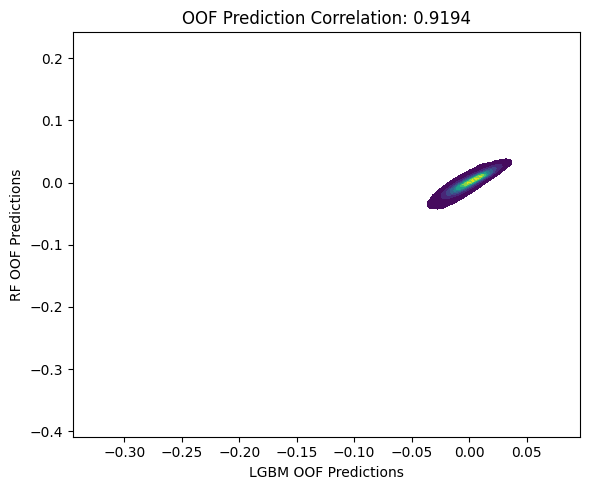

In [13]:
overall_corr = np.corrcoef(oof_lgb, oof_rf)[0, 1]
print(f"\nOverall OOF correlation between LGBM and RF: {overall_corr:.4f}")

plt.figure(figsize=(6, 5))
sns.kdeplot(x=oof_lgb, y=oof_rf, fill=True, cmap='viridis')
plt.title(f'OOF Prediction Correlation: {overall_corr:.4f}')
plt.xlabel('LGBM OOF Predictions')
plt.ylabel('RF OOF Predictions')
plt.tight_layout()
plt.show()

In [14]:
# =====================================================
# === Step 2: Tune alpha weight between LGBM & RF ===
# =====================================================
def objective_alpha(trial):
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    blend = alpha * oof_lgb + (1 - alpha) * oof_rf
    return np.sqrt(mean_squared_error(oof_y, blend))

study_alpha = optuna.create_study(direction="minimize")
study_alpha.optimize(objective_alpha, n_trials=40)
best_alpha = study_alpha.best_params["alpha"]
print(f"✅ Best alpha for blending: {best_alpha:.4f}")

[I 2025-10-24 15:22:40,396] A new study created in memory with name: no-name-00d209d0-3bd4-4b82-9263-384582f315c1
[I 2025-10-24 15:22:40,406] Trial 0 finished with value: 0.05602492035322796 and parameters: {'alpha': 0.5689334479622624}. Best is trial 0 with value: 0.05602492035322796.
[I 2025-10-24 15:22:40,414] Trial 1 finished with value: 0.0560027727664099 and parameters: {'alpha': 0.7061133158176806}. Best is trial 1 with value: 0.0560027727664099.
[I 2025-10-24 15:22:40,421] Trial 2 finished with value: 0.056011586073821236 and parameters: {'alpha': 0.6379839326955765}. Best is trial 1 with value: 0.0560027727664099.
[I 2025-10-24 15:22:40,430] Trial 3 finished with value: 0.056052655290044384 and parameters: {'alpha': 0.46713038816615526}. Best is trial 1 with value: 0.0560027727664099.
[I 2025-10-24 15:22:40,438] Trial 4 finished with value: 0.056149141282644276 and parameters: {'alpha': 0.240009989140765}. Best is trial 1 with value: 0.0560027727664099.
[I 2025-10-24 15:22:40,

✅ Best alpha for blending: 0.8083


In [15]:
# =====================================================
# === Step 3: Final blending using best alpha ===
# =====================================================
# recompute CV RMSE using best alpha
final_oof = best_alpha * oof_lgb + (1 - best_alpha) * oof_rf
final_rmse = np.sqrt(mean_squared_error(oof_y, final_oof))
print(f"Final blended OOF RMSE: {final_rmse:.5f}")

# re-blend test predictions using alpha
test_pred_final = best_alpha * test_pred_lgb + (1 - best_alpha) * test_pred_rf

Final blended OOF RMSE: 0.05600


In [16]:
# =====================================================
# === Optional Step: Ridge regression meta-blender ===
# =====================================================
from sklearn.linear_model import RidgeCV

print("\n--- Ridge Regression Meta-Blender ---")

meta_X = np.vstack([oof_lgb, oof_rf]).T
meta_y = oof_y

ridge = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
ridge.fit(meta_X, meta_y)
ridge_oof = ridge.predict(meta_X)
ridge_rmse = np.sqrt(mean_squared_error(meta_y, ridge_oof))
print(f"Ridge-blend OOF RMSE: {ridge_rmse:.5f}")
print("Ridge coefficients (LGBM, RF):", ridge.coef_)

# Predict on test set using same meta model
test_meta_X = np.vstack([test_pred_lgb, test_pred_rf]).T
test_pred_ridge = ridge.predict(test_meta_X)

# Optionally compare with Optuna alpha blend
print(f"Optuna alpha-blend OOF RMSE: {final_rmse:.5f}")
if ridge_rmse < final_rmse:
    print("✅ Ridge performs slightly better; using Ridge predictions.")
    test_pred_final = test_pred_ridge
else:
    print("ℹ️ Keeping Optuna alpha blend as final.")


--- Ridge Regression Meta-Blender ---
Ridge-blend OOF RMSE: 0.05600
Ridge coefficients (LGBM, RF): [0.81665426 0.18920576]
Optuna alpha-blend OOF RMSE: 0.05600
✅ Ridge performs slightly better; using Ridge predictions.


In [17]:
# =====================================================
# === Step 5: Save OOF and test predictions for stacking ===
# =====================================================

# Save OOF predictions for meta-learning later
oof_df = pd.DataFrame({
    'id': train_cat['id'],
    'oof_lgb': oof_lgb,
    'oof_rf': oof_rf,
    'oof_blend': final_oof,   # blended or ridge version
    'y_true': oof_y
})
oof_df.to_csv('oof_lgb_rf.csv', index=False)
print("✅ Saved OOF predictions to oof_lgb_rf.csv")

# Save test predictions (for later external blending)
test_stack_df = pd.DataFrame({
    'id': test_cat['id'],
    'test_lgb': test_pred_lgb,
    'test_rf': test_pred_rf,
    'test_blend': test_pred_final
})
test_stack_df.to_csv('test_lgb_rf.csv', index=False)
print("✅ Saved test predictions to test_lgb_rf.csv")

✅ Saved OOF predictions to oof_lgb_rf.csv
✅ Saved test predictions to test_lgb_rf.csv


In [18]:
# =====================================================
# === Step 4: Save final blended predictions ===
# =====================================================

# Combine optimized test predictions with baseline offset
final_preds = test_pred_final + test["y_base"]

submission = pd.DataFrame({
    'id': test_cat['id'],
    'accident_risk': final_preds
})

submission.to_csv('submission_rfblend.csv', index=False)
print("✅ submission_rfblend.csv ready for Kaggle upload!")

✅ submission_rfblend.csv ready for Kaggle upload!
